# Detecção de Casos de COVID-19 em Tomografias (versão PyTorch)
**Agenda**
- Carregar dataset (ImageFolder)
- Pré-processamento e augmentations
- Transfer Learning (ResNet18)
- Treino, validação, checkpoint, early stopping
- Avaliação final e plots


In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()  # Envie o arquivo kaggle.json


Saving archive (3).zip to archive (3).zip


In [ ]:
# Cell: Imports e configuração
import os
import random

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets, models

from sklearn.metrics import classification_report, confusion_matrix

# Configurações
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)


Device: cuda


In [ ]:
# Paths e hiper-parâmetros (ajuste aqui)
# DATA_DIR = "/kaggle/input"  # <-- ajuste para o caminho onde você extraiu o dataset
# The dataset was unzipped to /content/covid_dataset
DATA_DIR = "/content/covid_dataset"
# Espera-se uma estrutura: DATA_DIR/class1/*.png, DATA_DIR/class2/*.png (ImageFolder)
BATCH_SIZE = 16
IMG_SIZE = 224
NUM_EPOCHS = 25
LR = 2e-4
NUM_WORKERS = 4
PATIENCE = 6  # early stopping
MODEL_SAVE_PATH = "best_model_resnet18.pt"

In [ ]:
import zipfile
import os

# Path to the uploaded zip file
zip_path = '/content/archive (3).zip'
# Directory where the dataset will be extracted
extract_base_path = '/content/covid_dataset'

# Create the extraction directory if it doesn't exist
if not os.path.exists(extract_base_path):
    os.makedirs(extract_base_path)

# Unzip the file
print(f"Unzipping {zip_path} to {extract_base_path}...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_base_path)

print("Unzipping complete.")

# Optional: List contents to verify structure and find the actual dataset root
print("Contents of extracted directory:")
for root, dirs, files in os.walk(extract_base_path):
    level = root.replace(extract_base_path, '').count(os.sep)
    indent = ' ' * 4 * (level)
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 4 * (level + 1)
    for f in files:
        if not f.startswith('.'): # Ignore hidden files
            print(f'{subindent}{f}')
    if level > 1: # Limit depth for listing to avoid long output
        break

# The actual DATA_DIR should be adjusted based on the unzipped structure.
# Assuming the zip extracts into a folder named 'CT_Scan_Dataset' like:
# /content/covid_dataset/CT_Scan_Dataset/COVID
# /content/covid_dataset/CT_Scan_Dataset/Non-COVID
# The DATA_DIR variable is updated in cell 'nPLXoMoN7YCI' to reflect this.

Unzipping /content/archive (3).zip to /content/covid_dataset...
Unzipping complete.
Contents of extracted directory:
covid_dataset/
    non-COVID/
        Non-Covid (1133).png
        Non-Covid (399).png
        Non-Covid (145).png
        Non-Covid (410).png
        Non-Covid (624).png
        Non-Covid (1054).png
        Non-Covid (1210).png
        Non-Covid (202).png
        Non-Covid (621).png
        Non-Covid (458).png
        Non-Covid (237).png
        Non-Covid (850).png
        Non-Covid (17).png
        Non-Covid (669).png
        Non-Covid (14).png
        Non-Covid (169).png
        Non-Covid (1199).png
        Non-Covid (710).png
        Non-Covid (421).png
        Non-Covid (497).png
        Non-Covid (1177).png
        Non-Covid (451).png
        Non-Covid (10).png
        Non-Covid (531).png
        Non-Covid (46).png
        Non-Covid (157).png
        Non-Covid (299).png
        Non-Covid (348).png
        Non-Covid (1132).png
        Non-Covid (527).png
        Non

In [ ]:
# Augmentations e transforms
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# Carregar todo dataset via ImageFolder
full_dataset = datasets.ImageFolder(root=DATA_DIR, transform=train_transform)
class_names = full_dataset.classes
num_classes = len(class_names)
print("Classes:", class_names, "Num classes:", num_classes)

# Split train / val (ex.: 80/20)
val_ratio = 0.2
n_total = len(full_dataset)
n_val = int(n_total * val_ratio)
n_train = n_total - n_val

train_dataset, val_dataset = random_split(
    full_dataset,
    [n_train, n_val],
    generator=torch.Generator().manual_seed(SEED)
)

# Aplica a transformação de validação ao conjunto de validação
# Isso é necessário porque `random_split` herda a transformação do `full_dataset`
# que é `train_transform`. Precisamos aplicar `val_transform` ao `val_dataset`.
val_dataset.dataset.transform = val_transform

print(f"Tamanho train: {len(train_dataset)}, val: {len(val_dataset)}")

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

Classes: ['COVID', 'non-COVID'] Num classes: 2
Tamanho train: 1985, val: 496


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# Model (Transfer Learning com ResNet18)
def build_model(num_classes):
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    # Congelar todos os parâmetros do modelo pré-treinado
    for param in model.parameters():
        param.requires_grad = False

    # Substituir a camada final (fully connected) para nosso número de classes
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    model = model.to(DEVICE)
    return model

model = build_model(num_classes)
print(model)

# Loss e Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=LR) # Apenas camada final treinável

# Scheduler para ajuste do Learning Rate
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=PATIENCE // 2
)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 228MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Funções de treino e validação
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct_predictions / total_predictions
    return epoch_loss, epoch_acc

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct_predictions / total_predictions
    return epoch_loss, epoch_acc


# Loop de Treino
best_val_loss = float('inf')
epochs_no_improve = 0

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

print("Starting training...")
for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, DEVICE)

    scheduler.step(val_loss) # Atualiza o learning rate com base na val_loss

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Checkpoint e Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print("Model saved! Validation loss improved.")
    else:
        epochs_no_improve += 1
        print(f"Validation loss did not improve for {epochs_no_improve} epoch(s).")
        if epochs_no_improve == PATIENCE:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

print("Training complete.")

Starting training...
Epoch 1/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 10.74it/s]


Train Loss: 0.6174, Train Acc: 0.6650
Val Loss: 0.5535, Val Acc: 0.7258
Model saved! Validation loss improved.
Epoch 2/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.92it/s]


Train Loss: 0.5246, Train Acc: 0.7476
Val Loss: 0.4785, Val Acc: 0.7843
Model saved! Validation loss improved.
Epoch 3/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.14it/s]


Train Loss: 0.4648, Train Acc: 0.8091
Val Loss: 0.4396, Val Acc: 0.8125
Model saved! Validation loss improved.
Epoch 4/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.85it/s]


Train Loss: 0.4297, Train Acc: 0.8081
Val Loss: 0.4083, Val Acc: 0.8306
Model saved! Validation loss improved.
Epoch 5/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.97it/s]


Train Loss: 0.4118, Train Acc: 0.8302
Val Loss: 0.3915, Val Acc: 0.8387
Model saved! Validation loss improved.
Epoch 6/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.01it/s]


Train Loss: 0.3956, Train Acc: 0.8252
Val Loss: 0.3704, Val Acc: 0.8488
Model saved! Validation loss improved.
Epoch 7/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.07it/s]


Train Loss: 0.3698, Train Acc: 0.8453
Val Loss: 0.3637, Val Acc: 0.8589
Model saved! Validation loss improved.
Epoch 8/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.07it/s]


Train Loss: 0.3671, Train Acc: 0.8458
Val Loss: 0.3478, Val Acc: 0.8508
Model saved! Validation loss improved.
Epoch 9/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.72it/s]


Train Loss: 0.3618, Train Acc: 0.8524
Val Loss: 0.3726, Val Acc: 0.8327
Validation loss did not improve for 1 epoch(s).
Epoch 10/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.15it/s]


Train Loss: 0.3546, Train Acc: 0.8448
Val Loss: 0.3310, Val Acc: 0.8710
Model saved! Validation loss improved.
Epoch 11/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.23it/s]


Train Loss: 0.3326, Train Acc: 0.8690
Val Loss: 0.3269, Val Acc: 0.8609
Model saved! Validation loss improved.
Epoch 12/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.06it/s]


Train Loss: 0.3492, Train Acc: 0.8484
Val Loss: 0.3237, Val Acc: 0.8609
Model saved! Validation loss improved.
Epoch 13/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.99it/s]


Train Loss: 0.3352, Train Acc: 0.8625
Val Loss: 0.3184, Val Acc: 0.8710
Model saved! Validation loss improved.
Epoch 14/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.13it/s]


Train Loss: 0.3168, Train Acc: 0.8741
Val Loss: 0.3115, Val Acc: 0.8810
Model saved! Validation loss improved.
Epoch 15/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.08it/s]


Train Loss: 0.3205, Train Acc: 0.8615
Val Loss: 0.3026, Val Acc: 0.8730
Model saved! Validation loss improved.
Epoch 16/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.06it/s]


Train Loss: 0.3290, Train Acc: 0.8589
Val Loss: 0.3026, Val Acc: 0.8790
Validation loss did not improve for 1 epoch(s).
Epoch 17/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.00it/s]


Train Loss: 0.3177, Train Acc: 0.8695
Val Loss: 0.3028, Val Acc: 0.8770
Validation loss did not improve for 2 epoch(s).
Epoch 18/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.25it/s]


Train Loss: 0.3108, Train Acc: 0.8776
Val Loss: 0.2897, Val Acc: 0.9012
Model saved! Validation loss improved.
Epoch 19/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 12.09it/s]


Train Loss: 0.3120, Train Acc: 0.8746
Val Loss: 0.2858, Val Acc: 0.8871
Model saved! Validation loss improved.
Epoch 20/25


Validation: 100%|██████████| 31/31 [00:02<00:00, 10.72it/s]


Train Loss: 0.2996, Train Acc: 0.8746
Val Loss: 0.2875, Val Acc: 0.8851
Validation loss did not improve for 1 epoch(s).
Epoch 21/25


Validation: 100%|██████████| 31/31 [00:03<00:00,  9.92it/s]


Train Loss: 0.2998, Train Acc: 0.8796
Val Loss: 0.3044, Val Acc: 0.8649
Validation loss did not improve for 2 epoch(s).
Epoch 22/25


Validation: 100%|██████████| 31/31 [00:03<00:00,  9.31it/s]


Train Loss: 0.2956, Train Acc: 0.8836
Val Loss: 0.3159, Val Acc: 0.8569
Validation loss did not improve for 3 epoch(s).
Epoch 23/25


Validation: 100%|██████████| 31/31 [00:03<00:00,  9.26it/s]


Train Loss: 0.2996, Train Acc: 0.8741
Val Loss: 0.2745, Val Acc: 0.8992
Model saved! Validation loss improved.
Epoch 24/25


Validation: 100%|██████████| 31/31 [00:03<00:00,  8.62it/s]


Train Loss: 0.2828, Train Acc: 0.8831
Val Loss: 0.2752, Val Acc: 0.8972
Validation loss did not improve for 1 epoch(s).
Epoch 25/25


Validation: 100%|██████████| 31/31 [00:03<00:00,  8.50it/s]

Train Loss: 0.2808, Train Acc: 0.8892
Val Loss: 0.2711, Val Acc: 0.9032
Model saved! Validation loss improved.
Training complete.


In [ ]:
model = models.resnet18(pretrained=True)
# Substituir a última camada fully-connected
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

model = model.to(DEVICE)

# Se quiser "congelar" as camadas iniciais, descomente:
# for param in model.parameters():
#     param.requires_grad = False
# for param in model.fc.parameters():
#     param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    for inputs, labels in tqdm(loader, desc="Train", leave=False):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data).item()
        total += inputs.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_corrects / total
    return epoch_loss, epoch_acc

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Val", leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data).item()
            total += inputs.size(0)

            all_preds.extend(preds.cpu().numpy().tolist())
            all_labels.extend(labels.cpu().numpy().tolist())

    epoch_loss = running_loss / total
    epoch_acc = running_corrects / total
    return epoch_loss, epoch_acc, all_preds, all_labels


In [ ]:
best_val_loss = float('inf')
best_val_acc = 0.0
patience_counter = 0

history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"Epoch {epoch}/{NUM_EPOCHS}")
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc, _, _ = validate(model, val_loader, criterion, DEVICE)
    scheduler.step(val_loss)  # opcional

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f" train_loss: {train_loss:.4f} train_acc: {train_acc:.4f}")
    print(f" val_loss:   {val_loss:.4f} val_acc:   {val_acc:.4f}")

    # Checkpoint by val_loss (mudar se preferir val_acc)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_acc = val_acc
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'class_names': class_names
        }, MODEL_SAVE_PATH)
        print(" Saved best model.")
        patience_counter = 0
    else:
        patience_counter += 1
        print(f" Patience: {patience_counter}/{PATIENCE}")

    if patience_counter >= PATIENCE:
        print("Early stopping triggered.")
        break

print("Treino finalizado. Best val_loss:", best_val_loss, "best val_acc:", best_val_acc)


Epoch 1/25


Train:   0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


 train_loss: 0.2492 train_acc: 0.8882
 val_loss:   0.1705 val_acc:   0.9315
 Saved best model.
Epoch 2/25


 train_loss: 0.0486 train_acc: 0.9864
 val_loss:   0.0680 val_acc:   0.9778
 Saved best model.
Epoch 3/25


 train_loss: 0.0731 train_acc: 0.9768
 val_loss:   0.0645 val_acc:   0.9758
 Saved best model.
Epoch 4/25


 train_loss: 0.0614 train_acc: 0.9814
 val_loss:   0.0540 val_acc:   0.9698
 Saved best model.
Epoch 5/25


 train_loss: 0.0471 train_acc: 0.9839
 val_loss:   0.0737 val_acc:   0.9758
 Patience: 1/6
Epoch 6/25


 train_loss: 0.0325 train_acc: 0.9899
 val_loss:   0.0836 val_acc:   0.9738
 Patience: 2/6
Epoch 7/25


 train_loss: 0.0166 train_acc: 0.9960
 val_loss:   0.0249 val_acc:   0.9919
 Saved best model.
Epoch 8/25


 train_loss: 0.0053 train_acc: 0.9980
 val_loss:   0.0266 val_acc:   0.9899
 Patience: 1/6
Epoch 9/25


 train_loss: 0.0033 train_acc: 0.9995
 val_loss:   0.0095 val_acc:   0.9980
 Saved best model.
Epoch 10/25


 train_loss: 0.0015 train_acc: 1.0000
 val_loss:   0.0180 val_acc:   0.9919
 Patience: 1/6
Epoch 11/25


 train_loss: 0.0313 train_acc: 0.9909
 val_loss:   0.0472 val_acc:   0.9819
 Patience: 2/6
Epoch 12/25


 train_loss: 0.0418 train_acc: 0.9869
 val_loss:   0.2387 val_acc:   0.9214
 Patience: 3/6
Epoch 13/25


 train_loss: 0.0090 train_acc: 0.9975
 val_loss:   0.0301 val_acc:   0.9919
 Patience: 4/6
Epoch 14/25


 train_loss: 0.0062 train_acc: 0.9975
 val_loss:   0.0215 val_acc:   0.9919
 Patience: 5/6
Epoch 15/25


 train_loss: 0.0017 train_acc: 1.0000
 val_loss:   0.0287 val_acc:   0.9919
 Patience: 6/6
Early stopping triggered.
Treino finalizado. Best val_loss: 0.009547496510241482 best val_acc: 0.9979838709677419


In [ ]:
# Carregar melhor checkpoint
checkpoint = torch.load(MODEL_SAVE_PATH, map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE)
model.eval()

# Rodar validação final para obter previsões
val_loss, val_acc, preds, labels = validate(model, val_loader, criterion, DEVICE)
print("Val loss:", val_loss, "Val acc:", val_acc)

# Relatório
print("\nClassification Report:")
print(classification_report(labels, preds, target_names=class_names))

# Matriz de confusão
cm = confusion_matrix(labels, preds)
print("Confusion Matrix:\n", cm)


Val loss: 0.009547496510241482 Val acc: 0.9979838709677419

Classification Report:
              precision    recall  f1-score   support

       COVID       1.00      1.00      1.00       231
   non-COVID       1.00      1.00      1.00       265

    accuracy                           1.00       496
   macro avg       1.00      1.00      1.00       496
weighted avg       1.00      1.00      1.00       496

Confusion Matrix:
 [[231   0]
 [  1 264]]


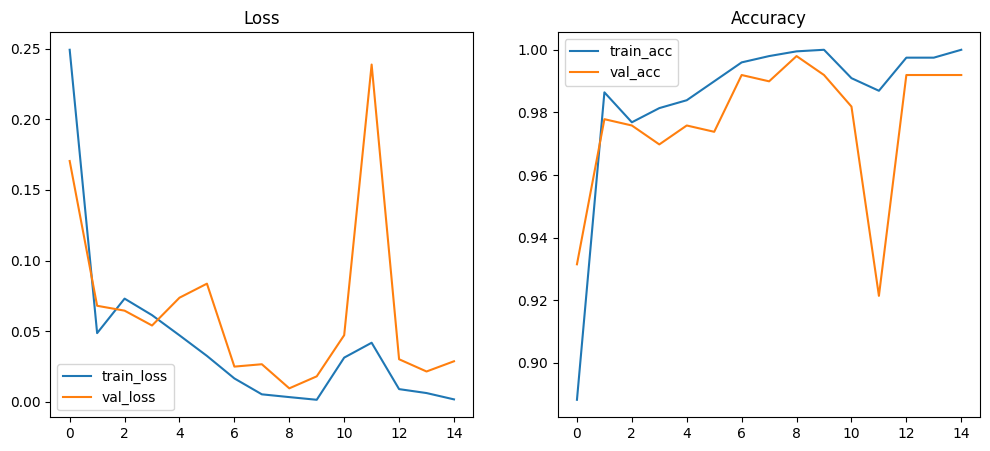

In [ ]:
# Plots simples
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history['train_acc'], label='train_acc')
plt.plot(history['val_acc'], label='val_acc')
plt.legend()
plt.title('Accuracy')

plt.show()


In [ ]:
# Salvar classes em arquivo para referência futura
import json
with open("class_names.json", "w") as f:
    json.dump(class_names, f, ensure_ascii=False, indent=2)
print("Class names saved to class_names.json")

print("Pronto. Para testar previsões individuais, carregue imagem, aplique val_transform e execute model(img.unsqueeze(0)).")


Class names saved to class_names.json
Pronto. Para testar previsões individuais, carregue imagem, aplique val_transform e execute model(img.unsqueeze(0)).


In [ ]:
# --- CÉLULA NOVA: Implementação da Classe GradCAM++ ---
import torch
import torch.nn.functional as F
import cv2
import numpy as np

class GradCAMPlusPlus:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Hooks para capturar o que acontece dentro da rede
        self.target_layer.register_forward_hook(self._save_activation)
        self.target_layer.register_backward_hook(self._save_gradient)

    def _save_activation(self, module, input, output):
        self.activations = output

    def _save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, input_tensor, class_idx=None):
        self.model.zero_grad()

        # Passar a imagem pelo modelo
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        # Backward pass focado na classe predita
        one_hot = torch.zeros_like(output).to(input_tensor.device)
        one_hot[0][class_idx] = 1
        output.backward(gradient=one_hot, retain_graph=True)

        gradients = self.gradients
        activations = self.activations

        # Matemática do Grad-CAM++ (trata melhor multiplos objetos que o Grad-CAM comum)
        b, k, u, v = gradients.size()
        alpha_num = gradients.pow(2)
        alpha_den = 2 * gradients.pow(2) + \
                    (activations * gradients.pow(3)).sum(dim=(2, 3), keepdim=True)
        alpha_den = torch.where(alpha_den != 0.0, alpha_den, torch.ones_like(alpha_den))

        alphas = alpha_num / alpha_den
        weights = (alphas * F.relu(gradients)).sum(dim=(2, 3), keepdim=True)

        heatmap = (weights * activations).sum(dim=1, keepdim=True)
        heatmap = F.relu(heatmap)

        # Processamento final da imagem do calor
        heatmap = heatmap.squeeze().cpu().detach().numpy()
        heatmap = cv2.resize(heatmap, (input_tensor.shape[2], input_tensor.shape[3]))

        # Normalizar entre 0 e 1
        if np.max(heatmap) - np.min(heatmap) != 0:
            heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))

        return heatmap

In [ ]:
# --- CÉLULA NOVA: Função para gerar e mostrar o Heatmap ---
import matplotlib.pyplot as plt
from PIL import Image

def visualizar_gradcam(model, image_path, transform, device, class_names):
    model.eval() # Modo de avaliação

    # Carregar imagem
    img_pil = Image.open(image_path).convert('RGB')
    input_tensor = transform(img_pil).unsqueeze(0).to(device)

    # Definir a camada alvo (Para ResNet18 é a última camada do layer4)
    target_layer = model.layer4[-1]

    # Inicializar GradCAM++
    grad_cam_pp = GradCAMPlusPlus(model, target_layer)

    # Gerar predição e heatmap
    output = model(input_tensor)
    pred_idx = output.argmax(dim=1).item()
    pred_prob = torch.nn.functional.softmax(output, dim=1)[0][pred_idx].item()

    heatmap = grad_cam_pp(input_tensor, class_idx=pred_idx)

    # Processar imagem original para exibição
    img_cv2 = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)
    img_cv2 = cv2.resize(img_cv2, (224, 224))

    # Criar mapa de calor colorido
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

    # Superpor (0.6 imagem original + 0.4 heatmap)
    superimposed = cv2.addWeighted(img_cv2, 0.6, heatmap_colored, 0.4, 0)
    superimposed = cv2.cvtColor(superimposed, cv2.COLOR_BGR2RGB)

    # Plotar
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(img_pil)
    plt.title("Imagem Original")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed)
    plt.title(f"Grad-CAM++\nPred: {class_names[pred_idx]} ({pred_prob*100:.1f}%)")
    plt.axis('off')

    plt.show()

Analisando imagem: Non-Covid (181).png


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


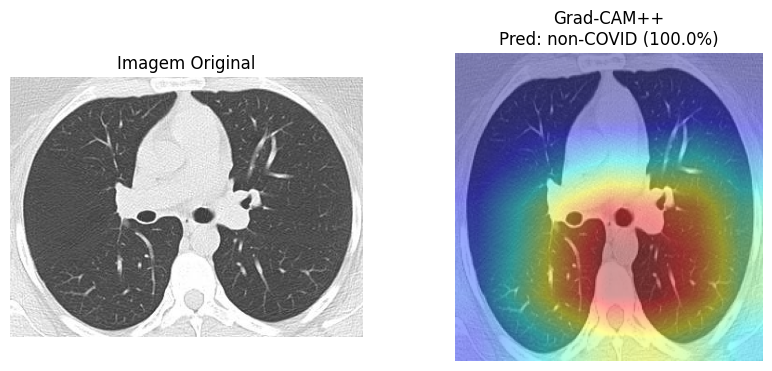

In [ ]:
# --- CÉLULA NOVA: Testando em uma imagem aleatória ---
import random
import os

# Certifique-se de que 'test_dir' e 'data_transforms' estão definidos (do seu código anterior)
# Usando DATA_DIR como o diretório de teste
test_dir = DATA_DIR

# Selecionar uma classe aleatória (COVID ou non-COVID)
classe_teste = 'non-COVID' # Ou mude para 'non-COVID'
pasta_classe = os.path.join(test_dir, classe_teste)

if os.path.exists(pasta_classe):
    imagens = os.listdir(pasta_classe)
    if len(imagens) > 0:
        imagem_aleatoria = random.choice(imagens)
        caminho_imagem = os.path.join(pasta_classe, imagem_aleatoria)

        print(f"Analisando imagem: {imagem_aleatoria}")

        # Chama a função criada acima
        visualizar_gradcam(
            model=model, # Seu modelo treinado
            image_path=caminho_imagem,
            transform=val_transform, # Suas transformações de validação/teste
            device=DEVICE,
            class_names=class_names
        )
    else:
        print("Nenhuma imagem encontrada na pasta.")
else:
    print(f"Pasta {pasta_classe} não encontrada. Verifique o caminho 'test_dir'.")

O aviso sobre o 'backward hook' (FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. Please use register_full_backward_hook to get the documented behavior.) está relacionado a como o PyTorch lida com a retropropagação (backward pass) do gradiente através da rede neural, especialmente quando você 'prende' (hook) funções para observar ou modificar o comportamento de certas camadas.

O que é um 'Hook' de Backward?
Em PyTorch, 'hooks' são funções que você pode registrar em módulos ou tensores para serem executadas quando certos eventos ocorrem, como antes ou depois de um forward pass, ou antes ou depois de um backward pass (cálculo de gradientes). No seu caso, o GradCAMPlusPlus usa um backward hook para capturar os gradientes que passam pela target_layer (a última camada do layer4 da ResNet18).

Por que o aviso aparece?
Antigamente, PyTorch permitia registrar backward hooks que recebiam apenas o gradiente de saída do módulo. No entanto, em modelos mais complexos (especialmente aqueles com múltiplos 'autograd Nodes' no forward pass, que significa caminhos múltiplos de computação ou conexões mais elaboradas), o gradiente de saída pode não ser o suficiente para uma compreensão completa ou para modificações precisas do gradiente de entrada de todas as partes.

O aviso está dizendo que, em versões futuras do PyTorch, o comportamento padrão dos backward hooks será alterado para exigir que eles sejam 'full' (completos), ou seja, que capturem e operem sobre todos os gradientes de entrada e saída, mesmo em módulos complexos. A recomendação é usar register_full_backward_hook em vez de register_backward_hook.

Implicações para o seu código:
Para o seu caso específico de Grad-CAM++, e como você o está usando (capturando grad_output[0]), este aviso não é um erro funcional. O código está funcionando conforme o esperado e o Grad-CAM++ está sendo visualizado corretamente. É uma sinalização de que o método que você está usando para o hook pode ser descontinuado no futuro e que o método register_full_backward_hook é o caminho a ser seguido para garantir compatibilidade futura e potencialmente lidar com casos mais complexos de grafos de computação.

Em resumo, não é algo para se preocupar agora, mas é bom ter em mente para futuras atualizações ou se você precisar de uma manipulação de gradientes mais sofisticada em projetos futuros.

## Implementando K-Fold Cross-Validation

In [ ]:
from sklearn.model_selection import StratifiedKFold
from copy import deepcopy

# Criar um dataset completo para o Cross-Validation
# full_dataset já foi carregado e tem as transformações de treino aplicadas
# Precisamos garantir que o dataset completo para o CV tenha as transformações adequadas.
# Para o CV, vamos querer que cada fold de treino use train_transform e cada fold de validação use val_transform
# Isso é um pouco mais complexo de gerenciar com ImageFolder diretamente se você não for cuidadoso.
# Uma forma é aplicar as transformações no DataLoader de cada fold. Por simplicidade,
# vamos usar o full_dataset com transform=None e então aplicar as transforms corretas via TransformedSubset.

# Preparar o dataset completo novamente, SEM transformações aplicadas inicialmente
full_dataset_cv = datasets.ImageFolder(root=DATA_DIR, transform=None)

# Extrair labels para StratifiedKFold
# ImageFolder.targets contém as labels para todas as imagens na ordem em que foram carregadas
y_labels = full_dataset_cv.targets

# Definir o número de folds
K_FOLDS = 5 # Você pode ajustar este valor
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)

print(f"Iniciando K-Fold Cross-Validation com K={K_FOLDS}")

fold_results = []

for fold, (train_index, val_index) in enumerate(skf.split(np.zeros(len(full_dataset_cv)), y_labels)):
    print(f"\n--- Fold {fold+1}/{K_FOLDS} ---")

    # Criar subconjuntos para o fold atual
    train_subset = torch.utils.data.Subset(full_dataset_cv, train_index)
    val_subset = torch.utils.data.Subset(full_dataset_cv, val_index)

    # Aplicar a transformação de validação ao subconjunto de validação.
    # Criamos um "wrapper" para aplicar a transformação correta.
    class TransformedSubset(torch.utils.data.Dataset):
        def __init__(self, subset, transform=None):
            self.subset = subset
            self.transform = transform

        def __getitem__(self, index):
            # A imagem aqui será uma PIL Image, pois full_dataset_cv foi criado com transform=None
            img, label = self.subset[index]
            if self.transform:
                img = self.transform(img)
            return img, label

        def __len__(self):
            return len(self.subset)

    train_data = TransformedSubset(train_subset, transform=train_transform)
    val_data = TransformedSubset(val_subset, transform=val_transform)

    # Criar DataLoaders para o fold atual
    train_loader_fold = DataLoader(
        train_data,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )
    val_loader_fold = DataLoader(
        val_data,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )

    # Re-inicializar o modelo para cada fold para garantir que ele comece do zero
    model_fold = build_model(num_classes) # Use a função build_model definida anteriormente
    optimizer_fold = optim.Adam(model_fold.fc.parameters(), lr=LR)
    scheduler_fold = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer_fold, mode='min', factor=0.1, patience=PATIENCE // 2
    )

    best_val_loss_fold = float('inf')
    epochs_no_improve_fold = 0
    current_fold_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(NUM_EPOCHS):
        # print(f"  Epoch {epoch+1}/{NUM_EPOCHS}") # Descomente para ver o progresso detalhado

        train_loss, train_acc = train_epoch(model_fold, train_loader_fold, criterion, optimizer_fold, DEVICE)
        val_loss, val_acc = validate_epoch(model_fold, val_loader_fold, criterion, DEVICE)

        scheduler_fold.step(val_loss)

        current_fold_history['train_loss'].append(train_loss)
        current_fold_history['train_acc'].append(train_acc)
        current_fold_history['val_loss'].append(val_loss)
        current_fold_history['val_acc'].append(val_acc)

        if val_loss < best_val_loss_fold:
            best_val_loss_fold = val_loss
            epochs_no_improve_fold = 0
            # Não salve o modelo de cada fold, a menos que seja estritamente necessário para não encher o disco
        else:
            epochs_no_improve_fold += 1
            if epochs_no_improve_fold == PATIENCE:
                # print(f"  Early stopping triggered for fold {fold+1} at epoch {epoch+1}.")
                break

    # No final do fold, carregue o melhor modelo salvo (se você o salvou)
    # Ou, para simplicidade, registre o melhor desempenho do fold
    final_val_loss, final_val_acc = validate_epoch(model_fold, val_loader_fold, criterion, DEVICE)
    fold_results.append({
        'fold': fold + 1,
        'val_loss': final_val_loss,
        'val_acc': final_val_acc,
        'history': current_fold_history
    })
    print(f"Fold {fold+1} - Final Val Loss: {final_val_loss:.4f}, Final Val Acc: {final_val_acc:.4f}")

# Agregação dos resultados de todos os folds
avg_val_loss = np.mean([res['val_loss'] for res in fold_results])
avg_val_acc = np.mean([res['val_acc'] for res in fold_results])

print("\n--- K-Fold Cross-Validation Completo ---")
print(f"Média da Validação Loss: {avg_val_loss:.4f}")
print(f"Média da Validação Accuracy: {avg_val_acc:.4f}")

Iniciando K-Fold Cross-Validation com K=5

--- Fold 1/5 ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Validation: 100%|██████████| 32/32 [00:02<00:00, 12.19it/s]


Fold 1 - Final Val Loss: 0.3787, Final Val Acc: 0.8310

--- Fold 2/5 ---


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.74it/s]


Fold 2 - Final Val Loss: 0.4283, Final Val Acc: 0.8125

--- Fold 3/5 ---


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.75it/s]


Fold 3 - Final Val Loss: 0.3834, Final Val Acc: 0.8347

--- Fold 4/5 ---


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.67it/s]


Fold 4 - Final Val Loss: 0.4002, Final Val Acc: 0.8246

--- Fold 5/5 ---


Validation: 100%|██████████| 31/31 [00:02<00:00, 11.75it/s]

Fold 5 - Final Val Loss: 0.3886, Final Val Acc: 0.8327

--- K-Fold Cross-Validation Completo ---
Média da Validação Loss: 0.3958
Média da Validação Accuracy: 0.8271


### Visualização das Curvas de Treino e Validação por Fold

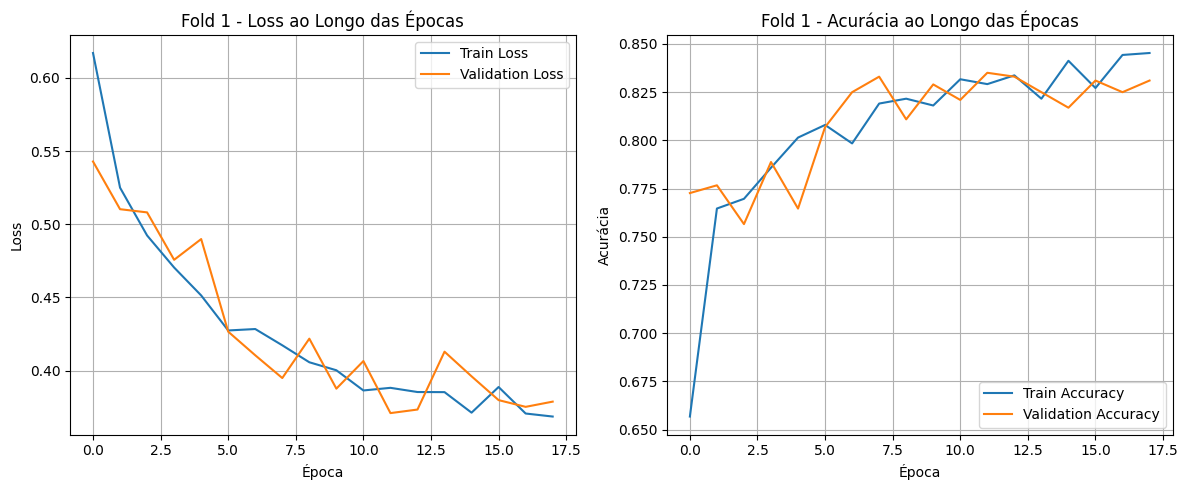

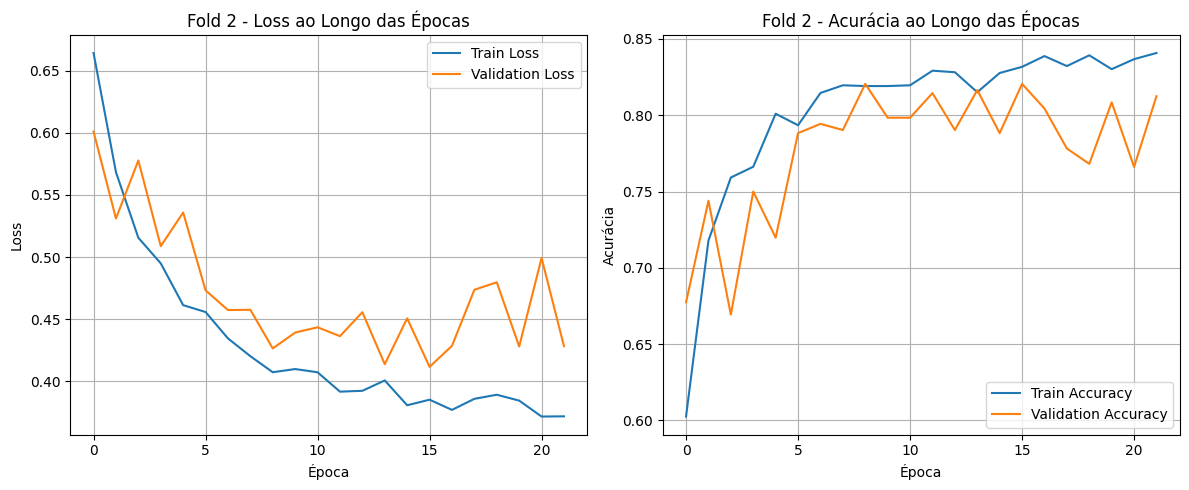

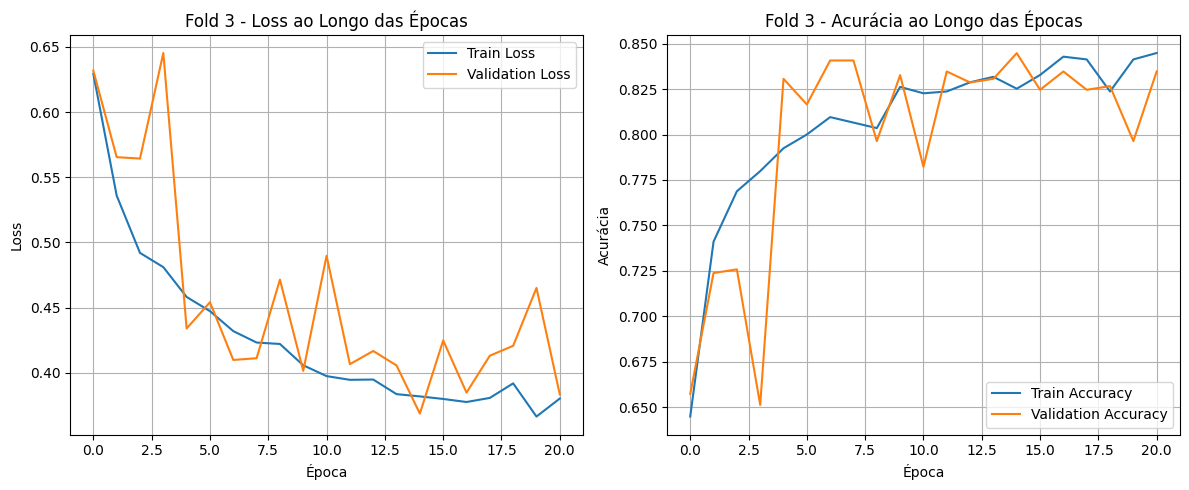

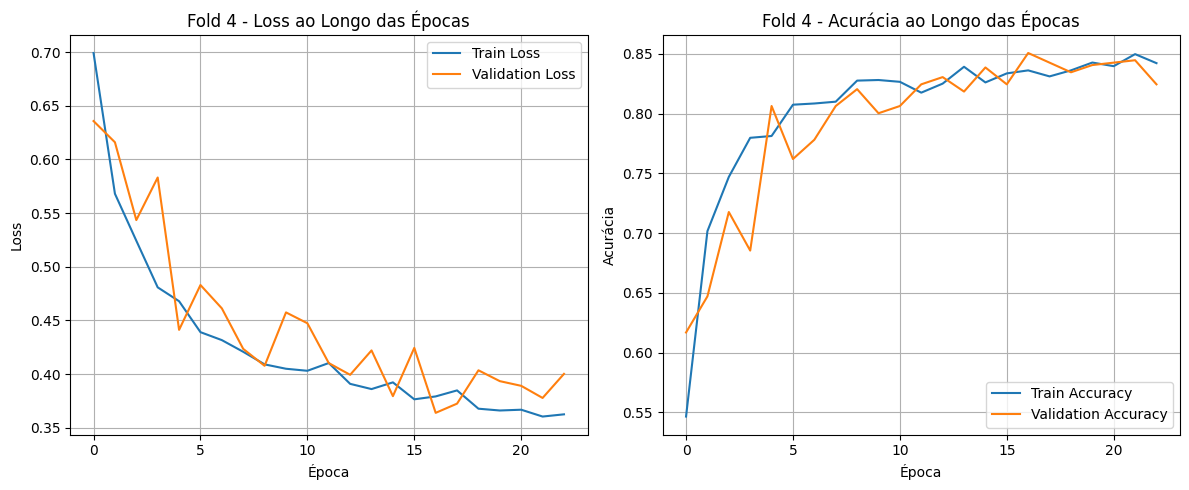

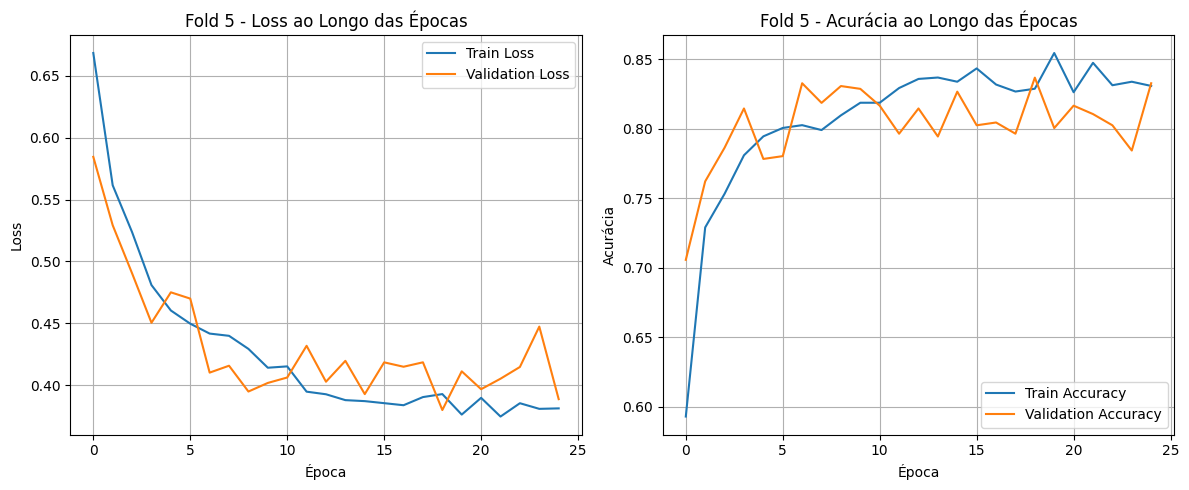

In [ ]:
import matplotlib.pyplot as plt

for fold_data in fold_results:
    fold_num = fold_data['fold']
    history = fold_data['history']

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'Fold {fold_num} - Loss ao Longo das Épocas')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title(f'Fold {fold_num} - Acurácia ao Longo das Épocas')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


Para comparar o desempenho entre os folds, podemos revisar as métricas de cada um e, em seguida, analisar a média:

Fold 1: Val Loss: 0.3787, Val Acc: 0.8310
Fold 2: Val Loss: 0.4283, Val Acc: 0.8125
Fold 3: Val Loss: 0.3834, Val Acc: 0.8347
Fold 4: Val Loss: 0.4002, Val Acc: 0.8246
Fold 5: Val Loss: 0.3886, Val Acc: 0.8327
--- Média Geral ---

Média da Validação Loss: 0.3958
Média da Validação Accuracy: 0.8271
Análise do Desempenho:

Podemos observar que os resultados entre os 5 folds são bastante consistentes. A acurácia de validação variou de 81.25% (Fold 2) a 83.47% (Fold 3), e a perda de validação de 0.3787 (Fold 1) a 0.4283 (Fold 2). Essa pequena variação indica que o modelo é estável e generaliza bem para diferentes subconjuntos dos dados. Não há um fold que se destaque negativamente, o que é um bom sinal de que o modelo não está superajustando a características específicas de um único conjunto de validação.

## Treino do Modelo Final com Dataset Completo

In [ ]:
# Re-criar o dataset completo com a transformação de treino
# O dataset original 'full_dataset' (do pré-processamento) já contém todas as imagens
# e foi criado com 'train_transform'.
# Para evitar problemas com 'random_split' e 'val_transform' sendo aplicado erroneamente,
# vamos garantir que o dataset completo para o treino final use apenas 'train_transform'.

final_full_dataset = datasets.ImageFolder(root=DATA_DIR, transform=train_transform)

# Criar DataLoader para o treinamento final
final_train_loader = DataLoader(
    final_full_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"Tamanho do dataset final para treino: {len(final_full_dataset)}")


Tamanho do dataset final para treino: 2481


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# Re-inicializar o modelo para o treino final
final_model = build_model(num_classes)

# Re-definir o otimizador e o critério de perda
final_criterion = nn.CrossEntropyLoss()
final_optimizer = optim.Adam(final_model.fc.parameters(), lr=LR)
final_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    final_optimizer,
    mode='min',
    factor=0.1,
    patience=PATIENCE // 2
)

# Loop de Treino para o Modelo Final
print("Iniciando treinamento do modelo final com o dataset completo...")

best_final_loss = float('inf')
epochs_no_improve_final = 0
final_model_save_path = "final_best_model_resnet18.pt"

final_history = {'train_loss': [], 'train_acc': []}

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")

    # Treinar no dataset completo
    train_loss, train_acc = train_epoch(final_model, final_train_loader, final_criterion, final_optimizer, DEVICE)

    # Nota: Não temos um conjunto de validação separado aqui para o early stopping
    # Vamos usar o 'train_loss' para o scheduler e para salvar o melhor modelo,
    # ou o modelo da última época será o final se não houver early stopping rigoroso.
    # Alternativamente, podemos dividir uma pequena parte do dataset final para validação
    # para o early stopping, mas para 'modelo final' é comum treinar em tudo.
    # Vamos usar o train_loss para o scheduler e salvar o melhor modelo *durante este treino*
    final_scheduler.step(train_loss)

    final_history['train_loss'].append(train_loss)
    final_history['train_acc'].append(train_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

    # Salvando o modelo com a melhor performance de treino (ou você pode ajustar para val_loss
    # se você quiser segregar uma pequena parte para validação durante este treino final)
    if train_loss < best_final_loss:
        best_final_loss = train_loss
        torch.save(final_model.state_dict(), final_model_save_path)
        print("Modelo final salvo! Perda de treino melhorou.")

print("Treinamento do modelo final concluído.")
print(f"Melhor modelo final salvo em: {final_model_save_path}")


Iniciando treinamento do modelo final com o dataset completo...
Epoch 1/25


Training: 100%|██████████| 156/156 [00:17<00:00,  9.10it/s]


Train Loss: 0.6447, Train Acc: 0.6247
Modelo final salvo! Perda de treino melhorou.
Epoch 2/25


Training: 100%|██████████| 156/156 [00:16<00:00,  9.30it/s]


Train Loss: 0.5235, Train Acc: 0.7662
Modelo final salvo! Perda de treino melhorou.
Epoch 3/25


Training: 100%|██████████| 156/156 [00:16<00:00,  9.53it/s]


Train Loss: 0.4901, Train Acc: 0.7743
Modelo final salvo! Perda de treino melhorou.
Epoch 4/25


Training: 100%|██████████| 156/156 [00:17<00:00,  8.98it/s]


Train Loss: 0.4618, Train Acc: 0.7985
Modelo final salvo! Perda de treino melhorou.
Epoch 5/25


Training: 100%|██████████| 156/156 [00:16<00:00,  9.49it/s]


Train Loss: 0.4375, Train Acc: 0.8110
Modelo final salvo! Perda de treino melhorou.
Epoch 6/25


Training: 100%|██████████| 156/156 [00:16<00:00,  9.58it/s]


Train Loss: 0.4204, Train Acc: 0.8267
Modelo final salvo! Perda de treino melhorou.
Epoch 7/25


Training: 100%|██████████| 156/156 [00:17<00:00,  9.02it/s]


Train Loss: 0.4102, Train Acc: 0.8251
Modelo final salvo! Perda de treino melhorou.
Epoch 8/25


Training: 100%|██████████| 156/156 [00:16<00:00,  9.61it/s]


Train Loss: 0.4000, Train Acc: 0.8267
Modelo final salvo! Perda de treino melhorou.
Epoch 9/25


Training: 100%|██████████| 156/156 [00:16<00:00,  9.52it/s]


Train Loss: 0.3975, Train Acc: 0.8323
Modelo final salvo! Perda de treino melhorou.
Epoch 10/25


Training: 100%|██████████| 156/156 [00:16<00:00,  9.50it/s]


Train Loss: 0.4013, Train Acc: 0.8142
Epoch 11/25


Training: 100%|██████████| 156/156 [00:17<00:00,  9.05it/s]


Train Loss: 0.3836, Train Acc: 0.8400
Modelo final salvo! Perda de treino melhorou.
Epoch 12/25


Training: 100%|██████████| 156/156 [00:16<00:00,  9.55it/s]


Train Loss: 0.3779, Train Acc: 0.8307
Modelo final salvo! Perda de treino melhorou.
Epoch 13/25


Training: 100%|██████████| 156/156 [00:16<00:00,  9.64it/s]


Train Loss: 0.3779, Train Acc: 0.8303
Epoch 14/25


Training: 100%|██████████| 156/156 [00:17<00:00,  8.94it/s]


Train Loss: 0.3785, Train Acc: 0.8295
Epoch 15/25


Training: 100%|██████████| 156/156 [00:16<00:00,  9.69it/s]


Train Loss: 0.3707, Train Acc: 0.8464
Modelo final salvo! Perda de treino melhorou.
Epoch 16/25


Training: 100%|██████████| 156/156 [00:16<00:00,  9.51it/s]


Train Loss: 0.3686, Train Acc: 0.8420
Modelo final salvo! Perda de treino melhorou.
Epoch 17/25


Training: 100%|██████████| 156/156 [00:16<00:00,  9.67it/s]


Train Loss: 0.3656, Train Acc: 0.8424
Modelo final salvo! Perda de treino melhorou.
Epoch 18/25


Training: 100%|██████████| 156/156 [00:17<00:00,  8.94it/s]


Train Loss: 0.3634, Train Acc: 0.8468
Modelo final salvo! Perda de treino melhorou.
Epoch 19/25


Training: 100%|██████████| 156/156 [00:16<00:00,  9.59it/s]


Train Loss: 0.3530, Train Acc: 0.8521
Modelo final salvo! Perda de treino melhorou.
Epoch 20/25


Training: 100%|██████████| 156/156 [00:16<00:00,  9.55it/s]


Train Loss: 0.3690, Train Acc: 0.8299
Epoch 21/25


Training: 100%|██████████| 156/156 [00:17<00:00,  9.00it/s]


Train Loss: 0.3591, Train Acc: 0.8400
Epoch 22/25


Training: 100%|██████████| 156/156 [00:16<00:00,  9.59it/s]


Train Loss: 0.3477, Train Acc: 0.8493
Modelo final salvo! Perda de treino melhorou.
Epoch 23/25


Training: 100%|██████████| 156/156 [00:16<00:00,  9.49it/s]


Train Loss: 0.3799, Train Acc: 0.8347
Epoch 24/25


Training: 100%|██████████| 156/156 [00:16<00:00,  9.56it/s]


Train Loss: 0.3591, Train Acc: 0.8444
Epoch 25/25


Training: 100%|██████████| 156/156 [00:17<00:00,  9.03it/s]


Train Loss: 0.3461, Train Acc: 0.8509
Modelo final salvo! Perda de treino melhorou.
Treinamento do modelo final concluído.
Melhor modelo final salvo em: final_best_model_resnet18.pt


Para avaliar o desempenho do modelo final de forma mais robusta, idealmente, precisaríamos de um conjunto de dados de teste totalmente separado que o modelo nunca tenha visto, mesmo durante o treinamento final com o final_full_dataset. Atualmente, o final_full_dataset inclui todos os dados usados no treinamento e validação anteriores.

Como você gostaria de prosseguir? Podemos:

Avaliar usando o conjunto de validação original (val_loader): Note que este conjunto foi incluído no final_full_dataset para o treinamento final, então não é uma avaliação completamente independente do desempenho de generalização.
Dividir o final_full_dataset em um novo conjunto de teste: Isso exigiria uma nova divisão e o modelo final já foi treinado em todo o final_full_dataset.

## Avaliação do Modelo Final

In [ ]:
# Re-inicializar o modelo com a arquitetura correta
final_model = build_model(num_classes)

# Carregar os pesos do modelo final salvo
checkpoint_final = torch.load(final_model_save_path, map_location=DEVICE)
final_model.load_state_dict(checkpoint_final)
final_model.to(DEVICE)
final_model.eval()

# Preparar o DataLoader para a avaliação do modelo final no dataset completo
# Usar full_dataset_cv sem transformações iniciais e aplicar val_transform via TransformedSubset
final_eval_dataset_raw = datasets.ImageFolder(root=DATA_DIR, transform=None)
final_eval_data = TransformedSubset(final_eval_dataset_raw, transform=val_transform)

final_eval_loader = DataLoader(
    final_eval_data,
    batch_size=BATCH_SIZE,
    shuffle=False, # Importante para manter a ordem para o relatório de classificação
    num_workers=NUM_WORKERS,
    pin_memory=True
)

# Rodar validação final para obter previsões
final_loss, final_acc, final_preds, final_labels = validate(final_model, final_eval_loader, final_criterion, DEVICE)
print(f"\nFinal Model - Loss: {final_loss:.4f}, Accuracy: {final_acc:.4f}")

# Relatório de Classificação
print("\nClassification Report (Modelo Final):")
print(classification_report(final_labels, final_preds, target_names=class_names))

# Matriz de Confusão
cm_final = confusion_matrix(final_labels, final_preds)
print("\nConfusion Matrix (Modelo Final):\n", cm_final)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                      


Final Model - Loss: 0.3413, Accuracy: 0.8509

Classification Report (Modelo Final):
              precision    recall  f1-score   support

       COVID       0.91      0.78      0.84      1252
   non-COVID       0.81      0.92      0.86      1229

    accuracy                           0.85      2481
   macro avg       0.86      0.85      0.85      2481
weighted avg       0.86      0.85      0.85      2481


Confusion Matrix (Modelo Final):
 [[ 978  274]
 [  96 1133]]


O modelo final foi avaliado! Aqui estão os resultados de desempenho:

Métricas Gerais:

Final Loss: 0.3413
Accuracy: 0.8509 (aproximadamente 85.09%)
Relatório de Classificação (Classification Report):

              precision    recall  f1-score   support

       COVID       0.91      0.78      0.84      1252
   non-COVID       0.81      0.92      0.86      1229

    accuracy                           0.85      2481
   macro avg       0.86      0.85      0.85      2481
weighted avg       0.86      0.85      0.85      2481
Matriz de Confusão (Confusion Matrix):

 [[ 978  274]
 [  96 1133]]
Análise dos Resultados:

Acurácia Geral: O modelo alcançou uma acurácia geral de 85.09% no dataset completo.
Classe COVID: Para a classe 'COVID', o modelo teve uma precisão de 91% (das imagens que ele classificou como COVID, 91% estavam corretas) e um recall de 78% (ele identificou 78% dos casos reais de COVID).
Classe non-COVID: Para a classe 'non-COVID', o modelo teve uma precisão de 81% e um recall de 92%. Ele é ligeiramente melhor em identificar corretamente casos não-COVID.
F1-Score: O F1-Score, que é uma média harmônica de precisão e recall, é de 0.84 para COVID e 0.86 para non-COVID.
Matriz de Confusão Detalhada:
978 imagens COVID foram corretamente classificadas como COVID (Verdadeiros Positivos).
274 imagens non-COVID foram incorretamente classificadas como COVID (Falsos Positivos).
96 imagens COVID foram incorretamente classificadas como non-COVID (Falsos Negativos).
1133 imagens non-COVID foram corretamente classificadas como non-COVID (Verdadeiros Negativos).
Estes resultados indicam que o modelo final tem um bom desempenho na detecção de COVID-19 em tomografias, com uma alta precisão para a classe COVID e um bom recall para a classe non-COVID.